In [1]:
"""  Brock A. et al "`Characterizing signal propagation to close the performance gap in unnormalized ResNets
<https://arxiv.org/pdf/2101.08692.pdf>`_"
"""

'  Brock A. et al "`Characterizing signal propagation to close the performance gap in unnormalized ResNets\n<https://arxiv.org/pdf/2101.08692.pdf>`_"\n'

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
class MNISTConvNet(nn.Module):

    def __init__(self):
        # this is the place where you instantiate all your modules
        # you can later access them using the same names you've given them in
        # here
        super(MNISTConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    # it's the forward function that defines the network structure
    # we're accepting only a single input in here, but if you want,
    # feel free to use more
    def forward(self, input):
        x = self.pool1(F.relu(self.conv1(input)))
        x = self.pool2(F.relu(self.conv2(x)))

        # in your model definition you can go full crazy and use arbitrary
        # python code to define your model structure
        # all these are perfectly legal, and will be handled correctly
        # by autograd:
        # if x.gt(0) > x.numel() / 2:
        #      ...
        #
        # you can even do a loop and reuse the same module inside it
        # modules no longer hold ephemeral state, so you can use them
        # multiple times during your forward pass
        # while x.norm(2) < 10:
        #    x = self.conv1(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x
    
net = MNISTConvNet()


def printnorm(self, input, output):
    # input is a tuple of packed inputs
    # output is a Tensor. output.data is the Tensor we are interested
    print('Inside ' + self.__class__.__name__ + ' forward')
    print('')
    print('input: ', type(input))
    print('input[0]: ', type(input[0]))
    print('output: ', type(output))
    print('')
    print('input size:', input[0].size())
    print('output size:', output.data.size())
    print('output norm:', output.data.norm())


net.conv2.register_forward_hook(printnorm)

out = net(torch.randn(1, 1, 28, 28))

Inside Conv2d forward

input:  <class 'tuple'>
input[0]:  <class 'torch.Tensor'>
output:  <class 'torch.Tensor'>

input size: torch.Size([1, 10, 12, 12])
output size: torch.Size([1, 20, 8, 8])
output norm: tensor(11.4150)


In [4]:
net._forward_hooks

OrderedDict()

In [5]:
# https://github.com/TylerYep/torchinfo/blob/e93aa4f405e86dca96f2da63cf019d4e2b4ce48c/torchinfo/torchinfo.py#L317

In [6]:
# SPP:

# # Average Channel Squared Mean:
# # np.mean(np.mean(y, axis=[0, 1, 2]) ** 2)
# # • Average Channel Variance:
# # np.mean(np.var(y, axis=[0, 1, 2]))
# # • Residual Average Channel Variance:
# # np.mean(np.var(f(x), axis=[0, 1, 2])) # y = f(x) + identity
    

# SPP for my ResNet from torch

In [7]:
from models_module.my_models import ResNet, ResBlock, ResNetLayer
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt

model = ResNet(1, 10, [128], [2])

In [8]:
# old code example of filtering

# ResNet_signal_propagation = []

# def hook(self, input, output) -> None:
#     # cache signals from ResBlocks
#     ResNet_signal_propagation.append(output.detach().numpy())

# def get_all_layers(net, instances_for_hook=(), instances_with_nested_objects=[]): 
#     if not isinstance(instances_for_hook, tuple):
#         instances_for_hook = tuple(instances_for_hook)        
    
#     # add nn.Sequential, nn.ModuleList to tuple of instances_with_nested_objects
#     for instance in (nn.Sequential, nn.ModuleList):
#         if instance not in instances_with_nested_objects:
#             if not isinstance(instances_with_nested_objects, list):
#                 instances_with_nested_objects = list(instances_with_nested_objects)
#             instances_with_nested_objects.append(instance)
#     if not isinstance(instances_with_nested_objects, tuple):
#         instances_with_nested_objects = tuple(instances_with_nested_objects)
    
#     for name, layer in net._modules.items():
#         if isinstance(layer, instances_with_nested_objects):
#             # get all nested objects
#             get_all_layers(layer, instances_for_hook, instances_with_nested_objects)
#         elif isinstance(layer, instances_for_hook):
#             # hook preferable layers outputs
#             layer.register_forward_hook(hook)

# get_all_layers(net, instances_for_hook=[ResBlock], instances_with_nested_objects=[ResNetLayer])
# out = net(torch.randn(1,1,28,28))

In [9]:
net._forward_hooks

OrderedDict()

In [10]:
class SignalPropagationStatistics:
    def __init__(self):
        self.statistics = { # хочу dict на случай, если будут добавляться какие-то новые статистики
            'Average Channel Squared Mean': [], 
            'Average Channel Variance': []
        }
        self.instances = []
        
    def add_new_statistics(self, tensor, instance):
        avg_ch_squared_mean = torch.mean(torch.mean(tensor, axis=1) ** 2).detach().numpy()
        avg_ch_var =  torch.mean(torch.var(tensor, axis=1)).detach().numpy()
        
        self.statistics['Average Channel Squared Mean'].append(avg_ch_squared_mean)
        self.statistics['Average Channel Variance'].append(avg_ch_var)
        self.instances.append(instance)
        

class ModelHooksForSPP:
    """ Manipulations with forward hooks of all network units for signal propagation plot."""
    def __init__(self):
        self.registered_hooks = []
        self.signal_propagation = SignalPropagationStatistics()
        
    def register_hook(self, module):
        # Check is it the lowest level
        submodules_amount =  sum(1 for _ in module.modules())
        if submodules_amount == 1: 
            self.registered_hooks.append(module.register_forward_hook(self.signal_propagation_hook))

        # Go deeper in network
        for child in module.children():
            self.register_hook(child)
        
    def signal_propagation_hook(self, module, input, output):
        # Cache signal statistics for each network unit
        instance = module.__class__.__name__
        self.signal_propagation.add_new_statistics(output, instance)
        print("============")

    
    def remove_hooks(self):
        for hook in self.registered_hooks:
            hook.remove()

class SPP:
    """ Signal Propagation Plots"""        
    def show_SPP_graphs(self, hook_class):
        """ Plot graphs of signal propagation statistics over networks units. """
        statistics_dict = hook_class.signal_propagation.statistics
        fig, axes = plt.subplots(1, len(statistics_dict), figsize=(15, 5))
        for (ax, (title, data)) in zip(axes, statistics_dict.items()):
            x = range(len(data))
            ax.plot(x, data)
            ax.set_title(title+" over network units", fontsize=14)
            ax.set_xlabel("Number of network unit", fontsize=12)
            ax.set_ylabel(title, fontsize=12)
        fig.show()
    
    def SPP_info(self, model, image_shape, batch_size=3, show_plots=True):
        """Signal propagation info.

        Collect signal propagation statistics and show signal propagation plots.

        """
        if len(image_shape) != 3:
            raise ValueError("Parameter image_shape must be a sequence of 3 elements (C, H, W)")
        image_shape = (batch_size, *image_shape)

        # Register forward hooks for all network units
        hook_class = ModelHooksForSPP()
        hook_class.register_hook(model)

        # Get hooks
        _ = model(torch.randn(image_shape)) # ResNet from batchflow need batch size more than 1 =(

        # Removing hooks:
#         hook_class.remove_hooks()
        
        signal_propagation_info = hook_class.signal_propagation

        # Show signal propagation plots
        if show_plots:
            self.show_SPP_graphs(hook_class)

        return hook_class.signal_propagation

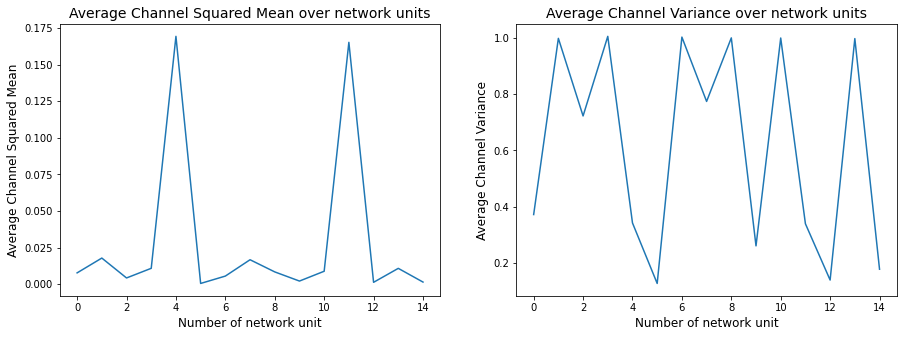

In [11]:
sp_info = SPP().SPP_info(model, image_shape=(1, 32, 32), batch_size=3, show_plots=True)

In [12]:
_ = model(torch.randn(3, 1, 28, 28))

In [13]:
print(len(sp_info.statistics['Average Channel Squared Mean'])) # must be 15
print(sp_info.instances)

15
['Conv2d', 'BatchNorm2d', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Conv2d', 'BatchNorm2d', 'Conv2d', 'BatchNorm2d', 'ReLU', 'Conv2d', 'BatchNorm2d', 'Linear']


# SPP for ResNet from batchflow

In [9]:
import sys
sys.path.append("..")

In [10]:
from batchflow.models.torch import ResNet

In [11]:
num_classes = 22
model_config = {
    'inputs/images/shape': (1, 28, 28), # can be commented
    'inputs/targets/classes': num_classes,
    'initial_block/inputs': 'images', # can be commented 
    'device': 'cpu'
}

model = ResNet(model_config).model

In [12]:
sp_info = SPP().SPP_info(model, image_shape=(1, 32, 32), batch_size=3, show_plots=True)

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512, 1, 1])

In [ ]:
print(len(sp_info.statistics['Average Channel Squared Mean'])) # must be 42
print(sp_info.instances)

# Third Model

надо протестировать на модельке, в которой реально несколько блоков внутри одного stage; 
изменить post-activation на pre-activation